In [1]:
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
df= pd.read_pickle("data/features.pkl")
df.head()

original_text  label  \
0  There is manuscript evidence that Austen conti...      1   
1  In a remarkable comparative analysis , Mandaea...      1   
2  Before Persephone was released to Hermes , who...      1   
3  Cogeneration plants are commonly found in dist...      1   
4  Geneva -LRB- , ; , ; , ; ; -RRB- is the second...      1   

                                        preprocessed  word_count  \
0  [there, is, manuscript, evidence, that, austen...          35   
1  [in, a, remarkable, comparative, analysis, man...          19   
2  [before, persephone, was, released, to, hermes...          40   
3  [cogeneration, plants, are, commonly, found, i...          32   
4  [geneva, is, the, city, in, switzerland, after...          20   

   avg_word_count  syllable_count  uncommon  difficult_words  \
0        4.485714        1.371429        14                7   
1        6.000000        1.789474        14                8   
2        4.725000        1.400000        15                9   
3        6.281250        1.781250        22               14   
4        4.650000        1.350000         7                4   

                                                stem  discourse  \
0  there is manuscript evid that austen continu t...          4   
1  there is manuscript evid that austen continu t...          2   
2  there is manuscript evid that austen continu t...          7   
3  there is manuscript evid that austen continu t...          0   
4  there is manuscript evid that austen continu t...          0   

   cohesive_features  flesch   dale  mcalpine  nouns_adjs  \
0                  2   52.87  11.24      48.0    0.228571   
1                  1   35.27  14.55      23.0    0.315789   
2                  3   47.80  11.15      57.0    0.175000   
3                  1   22.08  14.60      38.0    0.593750   
4                  2   68.10   8.58      29.0    0.400000   

                                          normalized  
0  there is manuscript evidence that austen conti...  
1  in a remarkable comparative analysis mandaean ...  
2  before persephone was released to hermes who h...  
3  cogeneration plants are commonly found in dist...  
4  geneva is the city in switzerland after zürich...

### Split dataset into test, train and dev

We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively. We'll use `split` from `numpy` to split the data into train, dev, and test separately. We'll call these `train_df`, `dev_df`, and `test_df`. It's important to note that `split` does not shuffle, so we'll use `DataFrame.sample()` and randomly resample our entire dataset to get a random shuffle before the split.

In [3]:
RANDOM_SEED= 42

In [4]:
# create a text column that holds our clean data set in a string format
df['text'] = [' '.join(map(str, l)) for l in df['preprocessed']]

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit # helps ensure that classes are balanced before testing
X = df[['text']].values
y = df[['label']].values

s = StratifiedShuffleSplit(n_splits=1, test_size =0.2, random_state=42)  

for train_index, test_index in s.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [25]:
len(y_train),len(y_test)

(322886, 80722)

### Convert text data to features

We'll be using a `TfIdfVectorizer` to convert the text into features.

Tfidf is a numerical statistic that is meant to reflect how important a word is to a document in a corpus. The tf–idf score increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word. This helps to adjust for the words that appear more frequently in general. 

I hypothesize that using tf-idf rarer words which are often harder to comprehend will have higher weights than easier words that appear more frequently.  

In [26]:
# intitialize our vectorizer
vectorizer= TfidfVectorizer(max_features=10000,ngram_range=(1,2)) # set max vocab to 10000

X_train_tfidf = vectorizer.fit_transform(X_train.flatten())
X_test_tfidf = vectorizer.transform(X_test.flatten())


In [27]:
# check the length of the vectors
len(vectorizer.vocabulary_)

10000

In [28]:
# check the shape of our data
X_train_tfidf.shape, X_test_tfidf.shape,

((322886, 10000), (80722, 10000))

### Fit the classifier on a subset of the data

Finally, let's fit the classifier. For a start we'll use `LogisticRegression`.To train our classifier, we first create a `LogisticRegression` object and call `fit` passing in `X_train` and `y_train`.

For this cell, let's just use the first 10,000 rows of `X_train` and `y_train` to fit the classifier. 

In general, when we have a large dataset, it's useful to go end-to-end and train one of these half-baked classifiers to verify that your model works as expected. 

*Notes:*
1. We use the `lbfgs` solver, as this generally Just Works™ and is fast.
2. `X_train` is a numpy array, so you'll need to use array indexing operations to get the first 10,000 rows.

In [29]:
clf=LogisticRegression(solver="lbfgs",random_state=RANDOM_SEED)

clf.fit(X_train_tfidf[:10000],np.array(y_train)[:10000])

/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

### Create Dummy classifiers

It's always important to contextualize our results by comparing it with naive classifiers. If these classifiers do well, then your task is easy! If not, then you can see how much better your system does at first. We'll use two different strategies using the [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) class. Create two `DummyClassifier` instances that use the `uniform` (guess randomly) and `most_frequent` strategies and fit these on the training data so we can compare them with our regressor that was trained on 10K instances. In general, you probably always want to at least compare with these two baselines in a classification task.

In [30]:
# YOUR CODE HERE

duni=DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)
dmos=DummyClassifier(strategy="most_frequent",random_state=RANDOM_SEED)

duni.fit(X_train_tfidf[:10000],np.array(y_train)[:10000])
dmos.fit(X_train_tfidf[:10000],np.array(y_train)[:10000])

DummyClassifier(random_state=42, strategy='most_frequent')

### Let's generate our predictions

In [31]:
clf_dev_preds=clf.predict(X_test_tfidf)
duni_dev_preds=duni.predict(X_test_tfidf)
dmos_dev_preds=dmos.predict(X_test_tfidf)

### Score our predictions

In [32]:
lr_f1 = f1_score(y_test, clf_dev_preds)
rand_f1 = f1_score(y_test, duni_dev_preds)
mf_f1 = f1_score(y_test, dmos_dev_preds)

In [33]:
print(lr_f1)
print(rand_f1)
print(mf_f1)

0.6666122943561542
0.5066888608741417
0.6765800475448808


## Train on the entire data set

In [34]:
clf2=LogisticRegression(solver="lbfgs",random_state=RANDOM_SEED)

clf2.fit(X_train_tfidf,np.array(y_train))

/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [35]:
clf2_test_preds=clf2.predict(X_test_tfidf)

In [36]:
clf2_f1 = f1_score(y_test, clf2_test_preds)
from sklearn.metrics import accuracy_score
clf2_acc =  accuracy_score(y_test,clf2_test_preds)
print("The f1_score of logistic regression is " + str(clf2_f1))
print("The accuracy of logistic regression is "+ str(clf2_acc))

The f1_score of logistic regression is 0.7071695940109416
The accuracy of logistic regression is 0.6976288991848567


Let's try and remove stop words and see if that helps things

# Logistic regression with stop words removed

In [37]:
X_train, X_test, y_train,y_test = train_test_split(df['text'], df['label'], 
                                                    test_size=0.2, random_state=42)

In [38]:
# intitialize our vectorizer
vect= TfidfVectorizer(max_features=10000,stop_words='english',ngram_range=(1,2)) # set max vocab to 10000

In [39]:
vect.fit(df['text'])

Train_X_Tfidf = vect.transform(X_train)
Test_X_Tfidf = vect.transform(X_test)

In [40]:
clf3=LogisticRegression(solver="lbfgs",random_state=RANDOM_SEED)

clf3.fit(Train_X_Tfidf,np.array(y_train))

/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [41]:
clf3_test_preds=clf3.predict(Test_X_Tfidf)

In [42]:
clf3_f1 = f1_score(y_test, clf3_test_preds)
print(clf2_f1)

0.7071695940109416


# Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(bootstrap= True,
 max_depth=50,
 max_features='auto',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators=800)

rf.fit(Train_X_Tfidf,y_train)
rf_preds = rf.predict(Test_X_Tfidf)
rf_acc = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_acc, rf_f1

/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


(0.6038874160699685, 0.697146212788528)

# Gradient Boosted Decision Tree

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

glf = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 10, random_state = 42)
glf.fit(Train_X_Tfidf, y_train.values)

GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=42)

In [47]:
glf_preds = glf.predict(Test_X_Tfidf)
glf_acc = accuracy_score(y_test, glf_preds)
glf_f1 = f1_score(y_test, glf_preds)
glf_acc, glf_f1

(0.6285894799435098, 0.574948607074502)

# XGBoost

In [48]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/util

In [49]:
xgb_cl = xgb.XGBClassifier()

In [50]:
xgb_cl.fit(Train_X_Tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
pre = xgb_cl.predict(Test_X_Tfidf)
acc_xgboost= accuracy_score(y_test, pre)
xg_boost_f1 = f1_score(y_test, pre)

print(acc_xgboost,xg_boost_f1)

0.6564381457347439 0.6272897095781425


# SVM

In [112]:
#from sklearn import svm
#from sklearn.metrics import accuracy_score, f1_score

In [ ]:
#SVM = svm.SVC(C=0.5, kernel='linear', degree=3, gamma='auto')
#SVM.fit(Train_X_Tfidf,y_train)

#pred_SVM = SVM.predict(Test_X_Tfidf)
#svm_acc = accuracy_score(y_test, pred_SVM)
#svm_f1 = f1_score(y_test, predictions_SVM)
#svm_acc, svm_f1

# Summary

In [54]:
# initialize list of lists
data = [['logistic_regression', 0.69760, 0.707169], ['random forest', 0.60236, 0.6970], \
        ['gradient_boosted', 0.62858, 0.57494],['XGBoost', 0.65643,0.62728]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['model', 'accuracy','f1_score'])

In [55]:
df

model  accuracy  f1_score
0  logistic_regression   0.69760  0.707169
1        random forest   0.60236  0.697000
2     gradient_boosted   0.62858  0.574940
3              XGBoost   0.65643  0.627280

In [56]:
#sns.barplot(data=df, x="model", y="accuracy")

dfs1 = pd.melt(df, id_vars = "model")
dfs1.head()

model  variable     value
0  logistic_regression  accuracy  0.697600
1        random forest  accuracy  0.602360
2     gradient_boosted  accuracy  0.628580
3              XGBoost  accuracy  0.656430
4  logistic_regression  f1_score  0.707169

In [60]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

/Users/manelmahroug/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<function matplotlib.pyplot.show(close=None, block=None)>

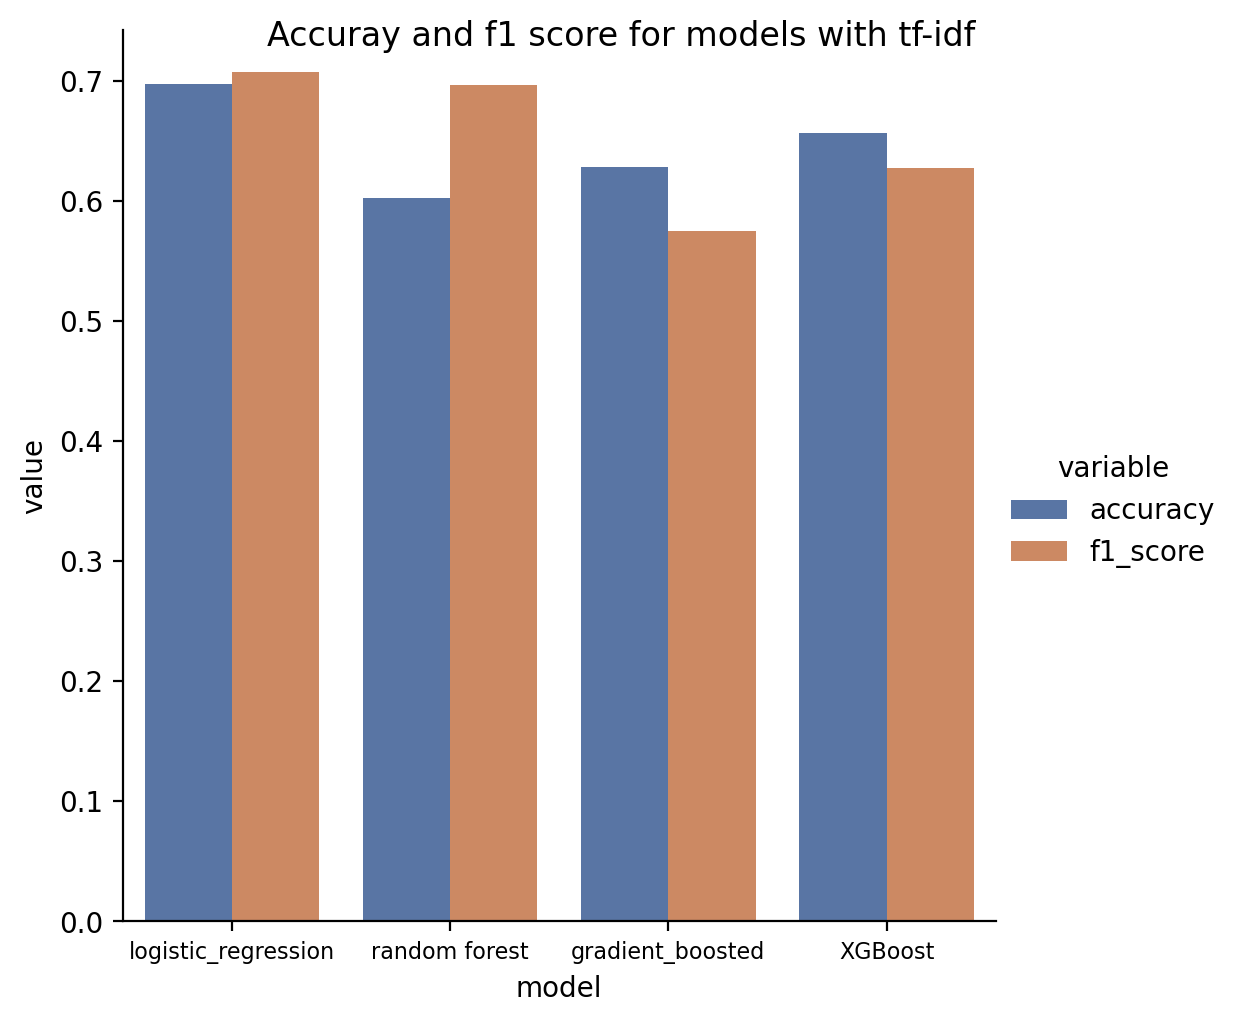

In [61]:
f= sns.factorplot(x = 'model', y='value', 
               hue = 'variable',data=dfs1,palette= 'deep',kind='bar')
f.set_xticklabels(fontsize= 8)
f.fig.suptitle('Accuray and f1 score for models with tf-idf', fontsize= 12)


plt.show